In [ ]:
import PyHEADTAIL
from PyHEADTAIL.particles import generators
from PyHEADTAIL.general.printers import SilentPrinter
from PyHEADTAIL.trackers.longitudinal_tracking import RFSystems
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.monitors.monitors import BunchMonitor
from SOLEILII_parameters.SOLEILII_CDR_parameters import *
import numpy as np
N_MACROPARTICLES = int(5e3)
# N_MACROPARTICLES_IONS = int(50)
# N_MACROPARTICLES_IONS_MAX = int(1e3)
N_TURNS = int(1)
H_RF = 416
N_SEGMENTS = int(500)
np.random.seed(42)
PHI_RF = np.arccos(U_LOSS/V_RF) if (GAMMA**-2-GAMMA_T**-2) < 0 else pi+np.arccos(U_LOSS/V_RF)
# print(e*U_LOSS/c/BETA)
PHI_RF=0
long_map = RFSystems(
    CIRCUMFERENCE,
    [H_RF],
    [V_RF],
    [PHI_RF],
    [ALPHA_0],
    GAMMA,
#     p_increment=0,
#     p_increment=U_LOSS/ENERGY,
    mass=m_e,
    charge=e
    )

In [ ]:
from PyHEADTAIL.particles import particles
from scipy.constants import m_p
from matplotlib import pyplot as plt
import seaborn as sbs
np.random.seed(42)
#Preparing custom electron bunch train
x_array = np.zeros(shape=(H_RF,))
xp_array = np.zeros(shape=(H_RF,))
y_array = np.zeros(shape=(H_RF,))
yp_array = np.zeros(shape=(H_RF,))
dp_array = np.zeros(shape=(H_RF,))
z_array = np.linspace(0, CIRCUMFERENCE-CIRCUMFERENCE/H_RF, H_RF)

electron_bunch_list = []
monitor_list = []
for ind, h in enumerate(range(H_RF)):
#     electron_bunch = particles.Particles(
#         macroparticlenumber=N_MACROPARTICLES,
#         particlenumber_per_mp=INTENSITY_PER_BUNCH,
#         charge=e,
#         mass=m_e,
#         circumference=CIRCUMFERENCE,
#         gamma=GAMMA,
#         coords_n_momenta_dict={'x': np.array([0, ]),
#                                'xp': np.array([0, ]),
#                                'y': np.array([0, ]),
#                                'yp': np.array([0, ]),
#                                'z': np.array([ind*CIRCUMFERENCE/H_RF, ]),
#                                'dp': np.array([0, ])
#                               }
#     )
    electron_bunch = generators.ParticleGenerator(macroparticlenumber=N_MACROPARTICLES,
                                                  intensity=INTENSITY_PER_BUNCH,
                                                  charge=e, gamma=GAMMA, mass=m_p,
                                                  circumference=CIRCUMFERENCE,
                                                  distribution_x=generators.gaussian2D(EPSILON_X),
                                                  alpha_x=ALPHA_X_SMOOTH, beta_x=BETA_X_SMOOTH,
                                                  distribution_y=generators.gaussian2D(EPSILON_Y),
                                                  alpha_y=ALPHA_Y_SMOOTH, beta_y=BETA_Y_SMOOTH,
                                                  distribution_z=generators.gaussian2D_asymmetrical(SIGMA_Z, SIGMA_DP),
                                                  limit_n_rms_x=3., limit_n_rms_y=3.,
                                                  printer=SilentPrinter()
                                     ).generate()
    filename = 'Results/BM_n={0:}'.format(int(h))
    bunch_monitor = BunchMonitor(filename, n_steps=N_SEGMENTS*N_TURNS, parameters_dict=None,
                 write_buffer_every=50, buffer_size=100,)
#     print(electron_bunch.mean_x())
    electron_bunch.z += h*CIRCUMFERENCE/H_RF
    electron_bunch_list.append(electron_bunch)
    monitor_list.append(bunch_monitor)
# ion_cloud = generators.ParticleGenerator(macroparticlenumber=N_MACROPARTICLES, intensity=.1*INTENSITY_PER_BUNCH,
#                                          charge=e, gamma=GAMMA, mass=28*m_p, circumference=CIRCUMFERENCE,
#                                          distribution_x=generators.uniform2D(0, 2*np.sqrt(EPSILON_X*5)),
#                                          alpha_x=ALPHA_X_SMOOTH, beta_x=BETA_X_SMOOTH,
#                                          distribution_y=generators.uniform2D(0, 2*np.sqrt(EPSILON_Y*5)),
#                                          alpha_y=ALPHA_Y_SMOOTH, beta_y=BETA_Y_SMOOTH,
#                                          distribution_z=generators.uniform2D(0, 2*SIGMA_Z),
#                                          limit_n_rms_x=3., limit_n_rms_y=3.,
#                                          printer=SilentPrinter()
#                                      ).generate()

In [3]:

# rfb = long_map.get_bucket(gamma=GAMMA, mass=m_e, charge=e)
# dpmax = rfb.dp_max(rfb.z_ufp_separatrix)
# # zz = np.linspace(2*rfb.z_left, 2*rfb.z_right, num=1000)
# zz = np.linspace(0, CIRCUMFERENCE, num=5000)
# ZZ, DP = np.meshgrid(zz, np.linspace(-dpmax*2.1, dpmax*2.1, num=5000))

# hh = rfb.hamiltonian(ZZ, DP, make_convex=False)
# # print(rfb.total_force(0))
# fig, ax = plt.subplots(1, 1)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(True)
# ax.spines['left'].set_visible(True)
# ax.contour(ZZ, DP, hh, label=None)

# # ax.plot(zz, rfb.separatrix(zz), c='purple', lw=6, linestyle='dashed', label='Separatrix')
# # ax.plot(zz, -rfb.separatrix(zz), c='purple', lw=6, linestyle='dashed', label=None)
# z0 = rfb.z_sfp # longitudinal position of the reference particle
# # ax.scatter(z0, 0, label='Reference particle', marker='o', color='black')
# ax.title.set_text('RF buckets')
# ax.set_xlabel('Longitudinal position $z$ (m)')
# ax.set_ylabel('Energy offset $dp/p_0$')
# # ax.scatter(electron_beam.z, electron_beam.dp)
# for electron_bunch in electron_bunch_list:
#     ax.scatter(electron_bunch.z, electron_bunch.dp)
# #     print('Electron bunch mean position: {:.2e}'.format(electron_bunch.mean_x()))
# #     print('Electron bunch rms position: {:.2e}, {:.2e}'.format(electron_bunch.sigma_x(), electron_bunch.sigma_y()))
# # ax.set_xlim(CIRCUMFERENCE-5*CIRCUMFERENCE/H_RF, CIRCUMFERENCE)
# plt.figlegend(frameon=False, loc='upper right')

In [4]:
s = np.arange(0, N_SEGMENTS + 1) * CIRCUMFERENCE / N_SEGMENTS
alpha_x, alpha_y = ALPHA_X_SMOOTH * \
    np.ones(N_SEGMENTS), ALPHA_Y_SMOOTH * np.ones(N_SEGMENTS)
beta_x, beta_y = BETA_X_SMOOTH * \
    np.ones(N_SEGMENTS), BETA_Y_SMOOTH * np.ones(N_SEGMENTS)
D_x, D_y = np.zeros(N_SEGMENTS),  np.zeros(N_SEGMENTS)

In [5]:
trans_map = TransverseMap(s, alpha_x, beta_x, D_x,
                              alpha_y, beta_y, D_y, Q_X, Q_Y)

In [6]:
from tqdm.notebook import tqdm
from PyHEADTAIL.field_maps import efields_funcs as efields
from PyHEADTAIL.general.element import Element
from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.general import pmath as pm
from scipy.constants import physical_constants
r_e = physical_constants['classical electron radius'][0]
class BeamIonElement(Element):
    def __init__(self,  sig_check=True, dist='GS', monitor_on = True, L_sep = 0.85):
        self.ion_beam = None
        self.dist = dist
        # self._efieldn = efields._efieldn_mit
        self._efieldn = efields._efieldn_linearized
        self.sig_check = sig_check
        self.L_sep = 0.85
        self.N_MACROPARTICLES = 50
        self.N_MACROPARTICLES_MAX = int(5e3)
        self.CIRCUMFERENCE = CIRCUMFERENCE 
        self.N_SEGMENTS = N_SEGMENTS
        if sig_check:
                self._efieldn = efields.add_sigma_check(
                    self._efieldn, self.dist)
        self.n_g = 2.4e13 # was 2.4e13
        self.sigma_i = 1.8e-22
        self.A = 28
        self.charge_state = 1
        self.ion_beam = particles.Particles(
                                            macroparticlenumber=1,
                                            particlenumber_per_mp=1,
                                            charge=self.charge_state*e,
                                            mass=self.A*m_p,
                                            circumference=CIRCUMFERENCE,
                                            gamma=1.0001,
                                            coords_n_momenta_dict=
                                            {
                                            'x': np.array([0, ]),
                                            'xp': np.array([0, ]),
                                            'y': np.array([0, ]),
                                            'yp': np.array([0, ]),
                                            'z': np.array([0, ]),
                                            'dp': np.array([0, ])
                                            }
                                            )
    def track(self, electron_bunch):
        '''Tracking method to track interaction between an electron bunch
        and an ion beam (2D electromagnetic field).
        The kicks are performed both for electron beam slice and for an ion beam. 
        Ion beam is tracked in a drift/space-charge of electron bunch sections. 
        
        Interaction is computed via Eqs. (17, 18) of 
        
        Tian, S. K.; Wang, N. (2018). Ion instability in the HEPS storage ring.
        FLS 2018 - Proceedings of the 60th ICFA Advanced Beam Dynamics Workshop on Future Light Sources,
        34–38. https://doi.org/10.18429/JACoW-FLS2018-TUA2WB04
        '''
        if self.ion_beam.macroparticlenumber < self.N_MACROPARTICLES_MAX:
            new_particles = generators.ParticleGenerator(
                                                    macroparticlenumber=self.N_MACROPARTICLES,
                                                    intensity=electron_bunch.intensity*self.sigma_i*self.n_g*self.CIRCUMFERENCE/self.N_SEGMENTS,
                                                    charge=self.charge_state*e,
                                                    gamma=1.0001,
                                                    mass=self.A*m_p,
                                                    circumference=CIRCUMFERENCE,
                                                    distribution_x=generators.gaussian2D(EPSILON_X),
                                                    alpha_x=ALPHA_X_SMOOTH, beta_x=BETA_X_SMOOTH,
                                                    distribution_y=generators.gaussian2D(EPSILON_Y),
                                                    alpha_y=ALPHA_Y_SMOOTH, beta_y=BETA_Y_SMOOTH,
                                                    distribution_z=generators.uniform2D(0, self.CIRCUMFERENCE/self.N_SEGMENTS),
                                                    limit_n_rms_x=3., limit_n_rms_y=3.,
                                                    printer=SilentPrinter()
                                                    ).generate()
            new_particles.xp[:] = 0
            new_particles.yp[:] = 0
            new_particles.x[:] += electron_bunch.mean_x()
            new_particles.y[:] += electron_bunch.mean_y()
            self.ion_beam+=new_particles
        else:
            self.ion_beam.intensity+=electron_bunch.intensity*self.sigma_i*self.n_g*self.CIRCUMFERENCE/self.N_SEGMENTS
#         print('intensity {0:.1e}, charge {1:.1e}'.format(self.ion_beam.intensity, self.ion_beam.charge))
        prefactor_kick_ion_field =  -(self.ion_beam.intensity*
                                     self.ion_beam.charge**2/
                                    (electron_bunch.gamma*m_e*c**2))
        prefactor_kick_electron_field = -(electron_bunch.intensity*
                                          electron_bunch.charge**2/
                                         (self.ion_beam.mass*c**2))
        assert (not np.isnan(prefactor_kick_ion_field)), 'Prefactor to electron kicks is NaN'
        assert (not np.isnan(prefactor_kick_electron_field)), 'Prefactor to ion kicks is NaN'
        # print('Prefactor kick electron field {:.1e}'.format(prefactor_kick_electron_field))
        # print('Prefactor kick ion field {:.1e}'.format(prefactor_kick_ion_field))
        # print('Ion cloud momentum {:.1e}'.format(self.ion_beam.p0))
        # print('Electron beam momentum {:.1e}'.format(electron_bunch.p0))
        
        p_id_electrons = electron_bunch.id-1
        p_id_ions = self.ion_beam.id-1
#         if len(p_id_electrons) == 0:
#                 continue
#Electric field of ions    
        en_ions_x, en_ions_y = self.get_efieldn(
                pm.take(electron_bunch.x, p_id_electrons),
                pm.take(electron_bunch.y, p_id_electrons),
                self.ion_beam.mean_x(), self.ion_beam.mean_y(),
                self.ion_beam.sigma_x(), self.ion_beam.sigma_y())
#Electric field of electrons        
        en_electrons_x, en_electrons_y = self.get_efieldn(
                pm.take(self.ion_beam.x, p_id_ions),
                pm.take(self.ion_beam.y, p_id_ions),
                electron_bunch.mean_x(),  electron_bunch.mean_y(),
                electron_bunch.sigma_x(), electron_bunch.sigma_y()
        )
        kicks_electrons_x = en_ions_x * prefactor_kick_ion_field
        kicks_electrons_y = en_ions_y * prefactor_kick_ion_field
        kicks_ions_x = en_electrons_x * prefactor_kick_electron_field
        kicks_ions_y = en_electrons_y * prefactor_kick_electron_field
#         print(kicks_ions_x)
        assert (not np.isnan(kicks_electrons_x.all())), 'kicks_electrons_x is NaN'
        assert (not np.isnan(kicks_electrons_y.all())), 'kicks_electrons_y is NaN'
        assert (not np.isnan(kicks_ions_x.all())), 'kicks_ions_x is NaN'
        assert (not np.isnan(kicks_ions_y.all())), 'kicks_ions_y is NaN'

        kicked_electrons_xp = pm.take(electron_bunch.xp, p_id_electrons) + kicks_electrons_x
        kicked_electrons_yp = pm.take(electron_bunch.yp, p_id_electrons) + kicks_electrons_y
        
        kicked_ions_xp = pm.take(self.ion_beam.xp, p_id_ions) + kicks_ions_x
        kicked_ions_yp = pm.take(self.ion_beam.yp, p_id_ions) + kicks_ions_y
        
        pm.put(electron_bunch.xp, p_id_electrons, kicked_electrons_xp)
        pm.put(electron_bunch.yp, p_id_electrons, kicked_electrons_yp)
        
        pm.put(self.ion_beam.xp, p_id_ions, kicked_ions_xp)
        pm.put(self.ion_beam.yp, p_id_ions, kicked_ions_yp)
        #Drift for the ions in one bucket
        # drifted_ions_x = pm.take(self.ion_beam.xp, p_id_ions)*self.L_sep+pm.take(self.ion_beam.x, p_id_ions)
        # drifted_ions_y = pm.take(self.ion_beam.yp, p_id_ions)*self.L_sep+pm.take(self.ion_beam.y, p_id_ions)
        # pm.put(self.ion_beam.x, p_id_ions, drifted_ions_x)
        # pm.put(self.ion_beam.y, p_id_ions, drifted_ions_y)   
    # def get_ion_beam(self):
        # return self.ion_beam
    def get_efieldn(self, xr, yr, mean_x, mean_y, sig_x, sig_y):
            '''The charge-normalised electric field components of a
            two-dimensional Gaussian charge distribution according to
            M. Bassetti and G. A. Erskine in CERN-ISR-TH/80-06.

            Return (E_x / Q, E_y / Q).
            '''
            x = xr - mean_x
            y = yr - mean_y

            # absolute values for convergence reasons of erfc
            en_x, en_y = self._efieldn(pm.abs(x), pm.abs(y), sig_x, sig_y)
            en_x = pm.abs(en_x) * pm.sign(x)
            en_y = pm.abs(en_y) * pm.sign(y)

            return en_x, en_y

In [7]:
trans_one_turn = [m for m in trans_map]
BI = BeamIonElement()
beam_ion_elements = []
for ind, m in enumerate(trans_one_turn):
    beam_ion_elements.append(BeamIonElement())
trans_one_turn = [item for sublist in zip(trans_one_turn, beam_ion_elements) for item in sublist]
print('First 5 elements of a transverse map: ')
for item in trans_one_turn[:5]:
    print(item) 
saved_xy = np.empty(shape=(4, H_RF, len(trans_one_turn)*N_TURNS))
print(saved_xy.shape)
saved_xy_ions = np.empty(shape=(4, H_RF, len(trans_one_turn)*N_TURNS))
for turn in tqdm(range(N_TURNS)):
# turn = 0
    for index, m_ in enumerate(tqdm(trans_one_turn)):
        for bunch_index, electron_bunch in enumerate(electron_bunch_list):
            m_.track(electron_bunch)    
            long_map.track(electron_bunch)
            if index % 2 ==0:
                monitor_list[bunch_index].dump(electron_bunch)
            # saved_xy[0, bunch_index, turn*len(trans_one_turn)+index] = electron_bunch.mean_x()
            # saved_xy[1, bunch_index, turn*len(trans_one_turn)+index] = electron_bunch.mean_y()
            # saved_xy[2, bunch_index, turn*len(trans_one_turn)+index] = electron_bunch.mean_xp()
            # saved_xy[3, bunch_index, turn*len(trans_one_turn)+index] = electron_bunch.mean_yp()

First 5 elements of a transverse map: 
(4, 416, 1000)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(0.0, 1.0)

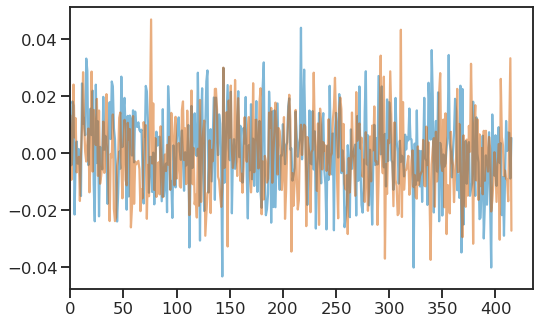

In [8]:
SIGMA_X = np.sqrt(EPSILON_X*np.mean(beta_x))
SIGMA_Y = np.sqrt(EPSILON_Y*np.mean(beta_y))

bunch_number = 0
# print(saved_xy[0, 0, ::2])
# turn = 200
# plt.plot(saved_xy[2, bunch_number, ::2]/SIGMA_X, alpha=.5, color='b', linestyle='dashed')
# plt.plot(saved_xy[3, bunch_number, ::2]/SIGMA_Y, alpha=.5, color='r', linestyle='dashed')
# print(saved_xy)
# plt.plot(saved_xy[0, bunch_number, ::2]/SIGMA_X, alpha=.5, color='b')
# plt.plot(saved_xy[1, bunch_number, ::2]/SIGMA_Y, alpha=.5, color='r')
# plt.plot(saved_xy[0, :, 15]/SIGMA_X, alpha=.5, color='b')
# plt.plot(saved_xy[1, :, 15]/SIGMA_Y, alpha=.5, color='r')

plt.xlim(0, )
# plt.ylim(-1, 1)

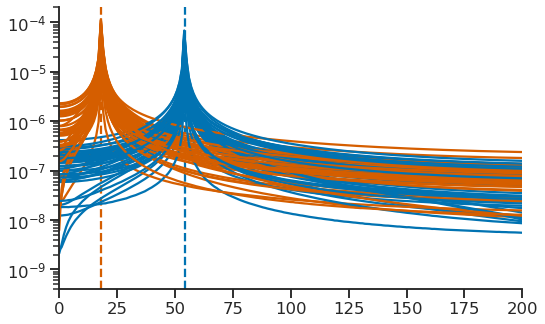

In [9]:
# from numpy.fft import rfft, fft, fftfreq, rfftfreq
# import seaborn as sbs
# sbs.set(rc={'figure.figsize':(8.3,5.2)},
#         style='ticks',
#         palette='colorblind',
#         context='talk', )
# f_0 = c/CIRCUMFERENCE
# f_s = f_0*len(trans_one_turn)//2
# bunch_number = -1
# fig, ax = plt.subplots(1, 1)
# ax.axvline(Q_X, color='b', linestyle='dashed')
# ax.axvline(Q_Y, color='r', linestyle='dashed')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(True)
# ax.spines['left'].set_visible(True)
# # ax.set_ylim(1e-1, )
# ax.set_xlim(0, .5*f_s/f_0)
# ax.set_xlim(0, 200)
# for bunch_number in range(H_RF)[::10]:
#     x, y = saved_xy[0, bunch_number, ::2], saved_xy[1, bunch_number, ::2]
#     fft_x, fft_y = (np.abs(rfft(x)), np.abs(rfft(y)))
#     fftfreq_x, fftfreq_y = f_s*rfftfreq(x.shape[0]), f_s*rfftfreq(y.shape[0]) 
#     ax.semilogy(fftfreq_x/f_0, fft_x, color='b')
#     ax.semilogy(fftfreq_y/f_0, fft_y, color='r')

In [10]:
# plt.plot(saved_xy[1, -1, :], label='electrons')
# plt.plot(saved_xy_ions[1, -1, :], label='ions')
# plt.xlim(0, 200)
# print(saved_xy_ions)

In [11]:
sigma_I = 1.8e-22
n_g = 2.4e14
print('Intensity of a single electron bunch: {0:.2e}'.format(INTENSITY_PER_BUNCH))
L_sep = 0.85
print('Intensity of ions generated by a single pass of an electron bunch: {0:.2e}'.format(INTENSITY_PER_BUNCH*sigma_I*n_g*L_sep))

Intensity of a single electron bunch: 8.85e+09
Intensity of ions generated by a single pass of an electron bunch: 3.25e+02


In [12]:
print('Horizontal emittance {0:.2e} and horizontal Twiss beta-function {1:.1f}'.format(EPSILON_X, beta_x[0]))
print('Vertical emittance {0:.2e} and vertical Twiss beta-function {1:.1f}'.format(EPSILON_Y, beta_y[0]))


Horizontal emittance 5.30e-11 and horizontal Twiss beta-function 1.0
Vertical emittance 5.30e-11 and vertical Twiss beta-function 3.1


1.0387356009100936 3.0933774488641244


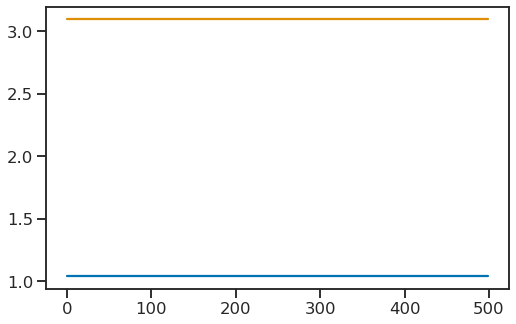

In [13]:
plt.plot(beta_x)
plt.plot(beta_y)
print(np.mean(beta_x), np.mean(beta_y))